In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from transformers import BertTokenizer,BertConfig,TFBertModel
import warnings
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
train_df = pd.read_csv('../data/train_set.csv', sep='\t', nrows=7000)
test_df = pd.read_csv('../data/test_a.csv', sep='\t')

In [3]:
train_df.head()

,label,text
0,2,2967 6758 339 2021 1854 3731 4109 3792 4149 15...
1,11,4464 486 6352 5619 2465 4802 1452 3137 5778 54...
2,3,7346 4068 5074 3747 5681 6093 1777 2226 7354 6...
3,2,7159 948 4866 2109 5520 2490 211 3956 5520 549...
4,3,3646 3055 3055 2490 4659 6065 3370 5814 2465 5...


In [4]:
tokenizer = BertTokenizer.from_pretrained('../emb/bert_base_chinese/vocab.txt')
tokenizer.encode_plus("2960 6758 339 2021",
        add_special_tokens=True,
        max_length=20,
        truncation=True)
# token_type_ids 通常第一个句子全部标记为0，第二个句子全部标记为1。
# attention_mask padding的地方为0，未padding的地方为1。

Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated


{'input_ids': [2, 5612, 1106, 1529, 518, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [5]:
def _convert_to_transformer_inputs(instance, tokenizer, max_sequence_length):
    """Converts tokenized input to ids, masks and segments for transformer (including bert)"""
    """默认返回input_ids,token_type_ids,attention_mask"""
    inputs = tokenizer.encode_plus(instance,
        add_special_tokens=True,
        max_length=max_sequence_length,
        truncation=True)

    input_ids =  inputs["input_ids"]
    input_masks = inputs["attention_mask"]
    input_segments = inputs["token_type_ids"]
    padding_length = max_sequence_length - len(input_ids)
    # 填充
    padding_id = tokenizer.pad_token_id
    input_ids = input_ids + ([padding_id] * padding_length)
    input_masks = input_masks + ([0] * padding_length)
    input_segments = input_segments + ([0] * padding_length)
    return [input_ids, input_masks, input_segments]


def compute_input_arrays(df, columns, tokenizer, max_sequence_length):
    input_ids, input_masks, input_segments = [], [], []
    for instance in tqdm(df[columns]):
        
        ids, masks, segments = _convert_to_transformer_inputs(str(instance), tokenizer, max_sequence_length)
        
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)

    return [np.asarray(input_ids, dtype=np.int32), 
            np.asarray(input_masks, dtype=np.int32), 
            np.asarray(input_segments, dtype=np.int32)
           ]

In [6]:
MAX_SEQUENCE_LENGTH = 128
input_categories = 'text'
inputs = compute_input_arrays(train_df, input_categories, tokenizer, MAX_SEQUENCE_LENGTH)
test_inputs = compute_input_arrays(test_df, input_categories, tokenizer, MAX_SEQUENCE_LENGTH)

100%|██████████| 50000/50000 [13:13<00:00, 63.01it/s]  


# 标签类别转换

In [7]:
output_categories = 'label'
def compute_output_arrays(df, columns):
    return np.asarray(df[columns].astype(int))
outputs = compute_output_arrays(train_df, output_categories)

# BERT模型

In [8]:
def Focal_Loss(y_true, y_pred, alpha=0.5, gamma=2):
    """
    focal loss for multi-class classification
    fl(pt) = -alpha*(1-pt)^(gamma)*log(pt)
    :param y_true: ground truth one-hot vector shape of [batch_size, nb_class]
    :param y_pred: prediction after softmax shape of [batch_size, nb_class]
    :param alpha:
    :param gamma:
    :return:
    """
    y_pred += tf.keras.backend.epsilon()
    ce = -y_true * tf.math.log(y_pred)
    weight = tf.pow(1 - y_pred, gamma) * y_true
    fl = ce * weight * alpha
    reduce_fl = tf.keras.backend.max(fl, axis=-1)
    return reduce_fl

In [9]:
def create_model():
    input_id = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)    
    input_mask = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)    
    input_atn = tf.keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32)
    
    config = BertConfig.from_pretrained('../emb/bert_base_chinese/bert-base-chinese-config.json', output_hidden_states=True)
    bert_model = TFBertModel.from_pretrained('../emb/bert_base_chinese/bert-base-chinese-tf_model.h5', config=config)
    
    sequence_output, pooler_output, hidden_states = bert_model(input_id, attention_mask=input_mask, token_type_ids=input_atn)
    # (bs,140,768)(bs,768)
    x = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)    
    x = tf.keras.layers.Dropout(0.15)(x)
    x = tf.keras.layers.Dense(14, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=[input_id, input_mask, input_atn], outputs=x)
    optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-5)
    FL = lambda y_true,y_pred: Focal_Loss(y_true, y_pred, alpha=0.25, gamma=2)
    model.compile(loss=FL, optimizer=optimizer, metrics=['acc'])
    return model

In [10]:
def history_look(history):
    history_dict = history.history

    acc = history_dict['acc']
    val_acc = history_dict['val_acc']
    loss=history_dict['loss']
    val_loss=history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(6,4))
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim((0.5,1))
    plt.show()

Train on 5600 samples, validate on 1400 samples
Epoch 1/7
5600/5600 [==============================] - 268s 48ms/sample - loss: 0.2905 - acc: 0.5082 - val_loss: 0.1589 - val_acc: 0.7250
Epoch 2/7
5600/5600 [==============================] - 245s 44ms/sample - loss: 0.1219 - acc: 0.7645 - val_loss: 0.1327 - val_acc: 0.7486
Epoch 3/7
5600/5600 [==============================] - 246s 44ms/sample - loss: 0.0730 - acc: 0.8332 - val_loss: 0.1157 - val_acc: 0.7814
Epoch 4/7
5600/5600 [==============================] - 246s 44ms/sample - loss: 0.0456 - acc: 0.8863 - val_loss: 0.0929 - val_acc: 0.8257
Epoch 5/7
5600/5600 [==============================] - 246s 44ms/sample - loss: 0.0273 - acc: 0.9220 - val_loss: 0.0996 - val_acc: 0.8286
Epoch 6/7
5600/5600 [==============================] - 247s 44ms/sample - loss: 0.0171 - acc: 0.9480 - val_loss: 0.0954 - val_acc: 0.8507
Epoch 7/7
5600/5600 [==============================] - 247s 44ms/sample - loss: 0.0145 - acc: 0.9530 - val_loss: 0.1103 - va

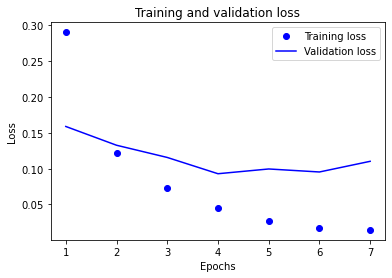

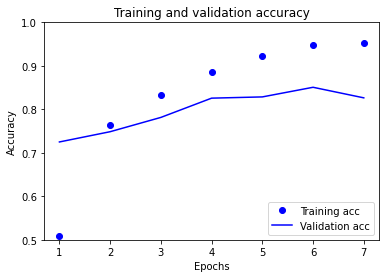

Train on 5600 samples, validate on 1400 samples
Epoch 1/7
5600/5600 [==============================] - 270s 48ms/sample - loss: 0.2842 - acc: 0.5121 - val_loss: 0.1896 - val_acc: 0.6457
Epoch 2/7
5600/5600 [==============================] - 245s 44ms/sample - loss: 0.1182 - acc: 0.7589 - val_loss: 0.1389 - val_acc: 0.7571
Epoch 3/7
5600/5600 [==============================] - 245s 44ms/sample - loss: 0.0704 - acc: 0.8425 - val_loss: 0.1084 - val_acc: 0.8079
Epoch 4/7
5600/5600 [==============================] - 244s 44ms/sample - loss: 0.0414 - acc: 0.8950 - val_loss: 0.1209 - val_acc: 0.7993
Epoch 5/7
5600/5600 [==============================] - 244s 44ms/sample - loss: 0.0287 - acc: 0.9207 - val_loss: 0.1250 - val_acc: 0.8071
Epoch 6/7
5600/5600 [==============================] - 244s 44ms/sample - loss: 0.0196 - acc: 0.9425 - val_loss: 0.1155 - val_acc: 0.8214
Epoch 7/7
5600/5600 [==============================] - 244s 44ms/sample - loss: 0.0165 - acc: 0.9496 - val_loss: 0.1190 - va

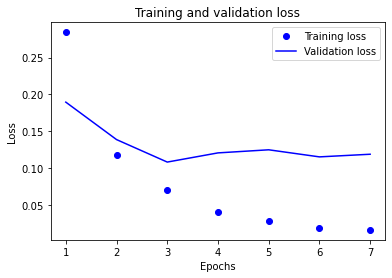

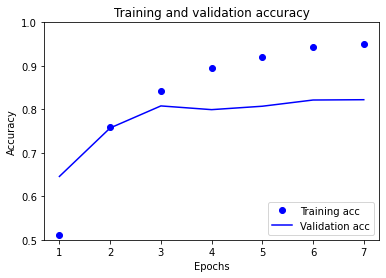

Train on 5600 samples, validate on 1400 samples
Epoch 1/7
5600/5600 [==============================] - 269s 48ms/sample - loss: 0.2947 - acc: 0.5041 - val_loss: 0.1538 - val_acc: 0.6986
Epoch 2/7
5600/5600 [==============================] - 243s 43ms/sample - loss: 0.1301 - acc: 0.7513 - val_loss: 0.1357 - val_acc: 0.7443
Epoch 3/7
5600/5600 [==============================] - 244s 43ms/sample - loss: 0.0743 - acc: 0.8389 - val_loss: 0.0998 - val_acc: 0.8029
Epoch 4/7
5600/5600 [==============================] - 244s 44ms/sample - loss: 0.0470 - acc: 0.8830 - val_loss: 0.0949 - val_acc: 0.8293
Epoch 5/7
5600/5600 [==============================] - 244s 44ms/sample - loss: 0.0279 - acc: 0.9184 - val_loss: 0.0997 - val_acc: 0.8350
Epoch 6/7
5600/5600 [==============================] - 244s 44ms/sample - loss: 0.0173 - acc: 0.9470 - val_loss: 0.1172 - val_acc: 0.8329
Epoch 7/7
5600/5600 [==============================] - 244s 44ms/sample - loss: 0.0147 - acc: 0.9530 - val_loss: 0.1360 - va

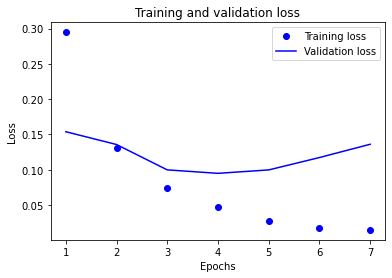

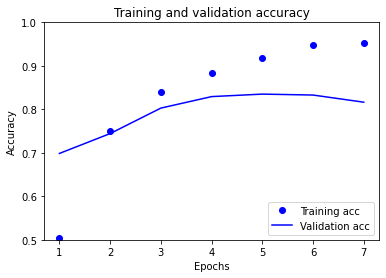

Train on 5600 samples, validate on 1400 samples
Epoch 1/7
5600/5600 [==============================] - 268s 48ms/sample - loss: 0.3133 - acc: 0.4841 - val_loss: 0.1663 - val_acc: 0.6979
Epoch 2/7
5600/5600 [==============================] - 243s 43ms/sample - loss: 0.1318 - acc: 0.7500 - val_loss: 0.1066 - val_acc: 0.7843
Epoch 3/7
5600/5600 [==============================] - 243s 43ms/sample - loss: 0.0808 - acc: 0.8341 - val_loss: 0.1381 - val_acc: 0.7621
Epoch 4/7
5600/5600 [==============================] - 242s 43ms/sample - loss: 0.0503 - acc: 0.8820 - val_loss: 0.0977 - val_acc: 0.8114
Epoch 5/7
5600/5600 [==============================] - 242s 43ms/sample - loss: 0.0302 - acc: 0.9146 - val_loss: 0.0947 - val_acc: 0.8286
Epoch 6/7
5600/5600 [==============================] - 242s 43ms/sample - loss: 0.0175 - acc: 0.9473 - val_loss: 0.1036 - val_acc: 0.8307
Epoch 7/7
5600/5600 [==============================] - 242s 43ms/sample - loss: 0.0125 - acc: 0.9589 - val_loss: 0.1027 - va

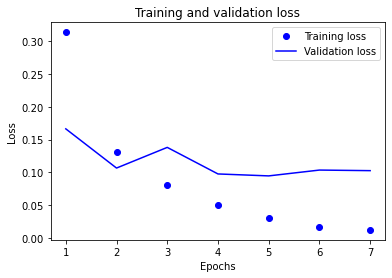

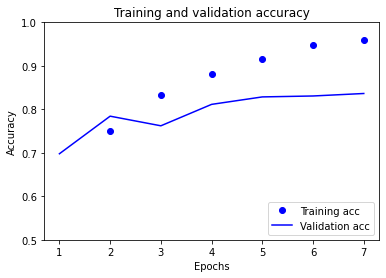

Train on 5600 samples, validate on 1400 samples
Epoch 1/7
5600/5600 [==============================] - 268s 48ms/sample - loss: 0.4813 - acc: 0.2023 - val_loss: 0.4645 - val_acc: 0.1593
Epoch 2/7
5600/5600 [==============================] - 242s 43ms/sample - loss: 0.4327 - acc: 0.2695 - val_loss: 0.2453 - val_acc: 0.5750
Epoch 3/7
5600/5600 [==============================] - 242s 43ms/sample - loss: 0.1689 - acc: 0.6934 - val_loss: 0.1196 - val_acc: 0.7721
Epoch 4/7
5600/5600 [==============================] - 243s 43ms/sample - loss: 0.0902 - acc: 0.8152 - val_loss: 0.1007 - val_acc: 0.8086
Epoch 5/7
5600/5600 [==============================] - 243s 43ms/sample - loss: 0.0545 - acc: 0.8777 - val_loss: 0.1053 - val_acc: 0.8100
Epoch 6/7
5600/5600 [==============================] - 243s 43ms/sample - loss: 0.0373 - acc: 0.9080 - val_loss: 0.1088 - val_acc: 0.8157
Epoch 7/7
5600/5600 [==============================] - 242s 43ms/sample - loss: 0.0207 - acc: 0.9411 - val_loss: 0.1029 - va

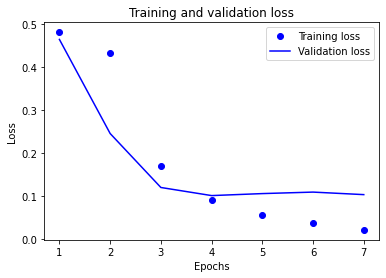

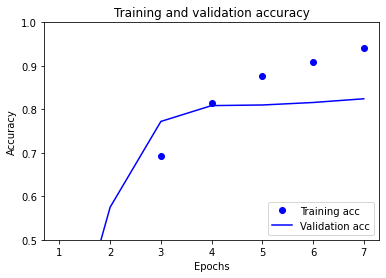

In [11]:
gkf = StratifiedKFold(n_splits=5).split(X=train_df[input_categories].fillna('-1'), y=train_df[output_categories].fillna('-1'))

valid_preds = []
test_preds = []
for fold, (train_idx, valid_idx) in enumerate(gkf):
    train_inputs = [inputs[i][train_idx] for i in range(len(inputs))]
    train_outputs = to_categorical(outputs[train_idx])

    valid_inputs = [inputs[i][valid_idx] for i in range(len(inputs))]
    valid_outputs = to_categorical(outputs[valid_idx])

    K.clear_session()  # 销毁当前的TF图并创建一个新图，有助于避免旧模型/图层混乱。
    model = create_model()
    history = model.fit(train_inputs, train_outputs, validation_data= [valid_inputs, valid_outputs], epochs=7, batch_size=6)
    history_look(history) 
    # model.save_weights(f'bert-{fold}.h5')
    valid_preds.append(model.predict(valid_inputs))
    test_preds.append(model.predict(test_inputs))

In [12]:
preds = np.average(test_preds, axis=0)
preds = np.argmax(preds,axis=1)

In [13]:
submission = pd.read_csv('../data/test_a_sample_submit.csv')
submission['label'] = preds
submission.to_csv('../output/BERT_submission.csv', index=False)